In [2]:
######################################################
# Example of usage of BUOYtools class
# to process OMB and SIMBA buoy data
#
# Current functionality:
# - reading and parsing text files with buoy positions (OMB and FMI SIMBA)
# - export to GIS ESRI shapefile format
# - plotting buoy tracks on a map (automatically calculated extent, manually defined)
# - putting labels at the end of buoy trajectory
# - plot selected set of buoys by its ID number
# - selection by start and end time
# - label with start date at the begining of buoy trajectory
# - get buoy IDs
# - clean up data from artificial buoy positions based on buoy speed thershold
# - add coincident reanalysis data (currently CARRA)
#
# TODO:
# 
# - ice deformation code
# - export to geojson
# 
#
#######################################################

In [3]:
from buoyTOOLS import *
import warnings
warnings.filterwarnings('ignore')


## Uncomment to set path pyproj
# import pyproj
# path = "/home/denis/.conda/envs/proba/lib/python3.10/site-packages/pyproj/proj_dir/share/proj"
# # new_data_dir = "/path/to/your/new/data/directory"
# # Set the new data directory
# pyproj.datadir.set_data_dir(path)
# # Verify that the data directory has been changed
# updated_data_dir = pyproj.datadir.get_data_dir()
# print("Updated PROJ Data Directory:", updated_data_dir)

In [5]:
# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              start_date_ll=[206810],
              end_date_ll=[206810],
              start_date='20230529070000',
              end_date='20230530170000',
              buoy_ids=[206817, 206795, 209584])


# Convert CSV files to shapefile format
b.csv2shp()

# Plot buoy trajectories
#b.plot_tracks(out_png_filename='/home/denis/test2.png', plot_end_date=True)

#map_extent = [1, 17, 78, 80.5]
#buoy_ids=[1002,1001, 1003, 206810]

Filtering data drifter_209584_coords.txt by speed threshold of 10 m/s
Filtering data drifter_206795_coords.txt by speed threshold of 10 m/s
Filtering data drifter_206817_coords.txt by speed threshold of 10 m/s


In [4]:

# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              start_date_ll=[206810],
              end_date_ll=[206810],
              start_date='20230522000000',
              end_date='20230605000000',
              buoy_ids=[206810])


# Convert CSV files to shapefile format
b.csv2shp()

# Plot buoy trajectories
# b.plot_tracks(out_png_filename=f'/data/rrs/seaice/drifters_scripts/plots/all_buoys.png',
#               plot_start_date=True,
#               plot_end_date=True)

Filtering data drifter_206810_coords.txt by speed threshold of 10 m/s


In [5]:
b.data['drifter_206810_coords.txt']

,# Time,Latitude,Longitude,Speed,Direction
0,2023-05-22 10:00:39,79.372183,0.018689,None,None
1,2023-05-22 10:30:36,79.368644,0.022176,0.223498,169.69
2,2023-05-22 11:00:38,79.364942,0.024280,0.230642,174.01
3,2023-05-22 11:30:41,79.361568,0.025233,0.209228,177.01
4,2023-05-22 12:00:40,79.358606,0.025418,0.18385,179.34
...,...,...,...,...,...
593,2023-06-04 21:30:27,76.596675,-7.065869,0.635901,194.81
594,2023-06-04 22:00:37,76.586470,-7.077870,0.652402,195.26
595,2023-06-04 22:30:39,76.576112,-7.089338,0.662531,194.42
596,2023-06-04 23:00:40,76.565558,-7.100613,0.674027,193.94


In [10]:
# Get buoy IDs
b.get_buoy_ids()

{1001, 1002, 1003, 206795, 206810, 206817, 209056, 209064, 209584, 209591}

Filtering data drifter_209056_coords.txt by speed threshold of 10 m/s


AttributeError: 'GeoAxes' object has no attribute 'outline_patch'

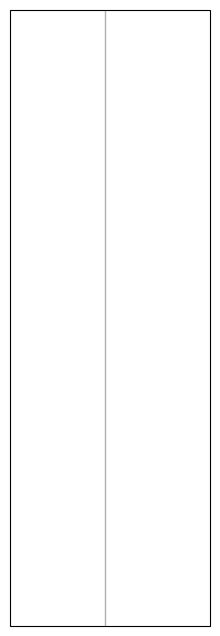

In [11]:
# Plot individual buoy tracks

# Initialize buoy data
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              buoy_ids=None)

for b_id in b.get_buoy_ids():
    b1 = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
                   shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
                   start_date_ll=[b_id],
                   end_date_ll=[b_id],
                   buoy_ids=[b_id],
                   start_date='20230522000000')

    # Convert CSV files to shapefile format
    b1.csv2shp()

#     # Plot buoy trajectories
    b1.plot_tracks(out_png_filename=f'/data/rrs/seaice/drifters_scripts/plots/{b_id}.png',
                  plot_start_date=True,
                  plot_end_date=True)

Filtering data drifter_209056_coords.txt by speed threshold of 10 m/s
Filtering data drifter_209584_coords.txt by speed threshold of 10 m/s
Filtering data drifter_206795_coords.txt by speed threshold of 10 m/s
Filtering data FMI1001GPS_final.csv by speed threshold of 10 m/s
Filtering data drifter_206817_coords.txt by speed threshold of 10 m/s
Filtering data FMI1003GPS_final.csv by speed threshold of 10 m/s
dropping time diff. of 1.0 s, dt0: 2023-06-02 10:30:14 dt1: 2023-06-02 10:30:15 
Filtering data drifter_206810_coords.txt by speed threshold of 10 m/s
dropping time diff. of 5.0 s, dt0: 2023-07-06 14:00:31 dt1: 2023-07-06 14:00:36 
Filtering data FMI1002GPS_final.csv by speed threshold of 10 m/s
Filtering data drifter_209064_coords.txt by speed threshold of 10 m/s
Filtering data drifter_209591_coords.txt by speed threshold of 10 m/s


2023-10-11 16:38:56,801 ERROR PROJ: proj_identify: /home/denis/.conda/envs/proba/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-10-11 16:38:56,802 INFO Failed to auto identify EPSG: 7
2023-10-11 16:38:56,849 ERROR PROJ: proj_identify: /home/denis/.conda/envs/proba/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-10-11 16:38:56,850 INFO Failed to auto identify EPSG: 7
2023-10-11 16:38:56,905 ERROR PROJ: proj_identify: /home/denis/.conda/envs/proba/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
2023-10-11 16:38:56,906 INFO Failed to auto identify EPSG: 7
2023-10-11 16:38:57,033 ERROR PROJ: proj_identify: /home/denis/.conda/envs/proba/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSIO

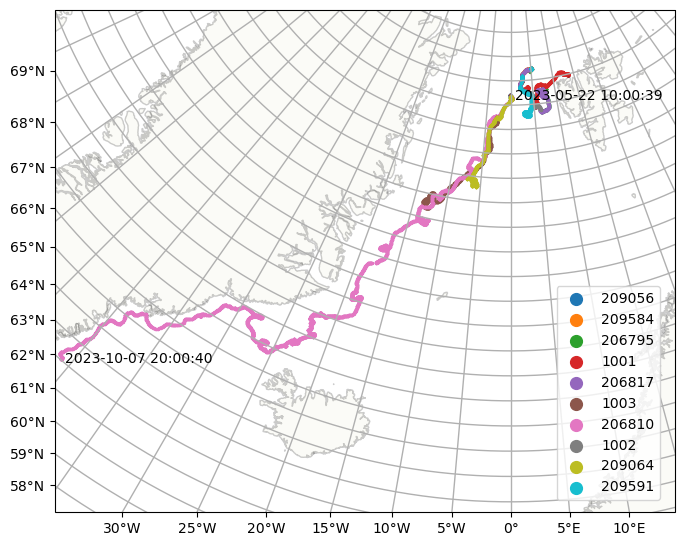

In [131]:
# Plot all buoys on a map
b = BUOYtools(buoy_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/text_files',
              shp_dir='/data/rrs/seaice/drifters_scripts/drift_data/test/shp',
              buoy_ids=None,
              start_date_ll=[206810],
              end_date_ll=[206810],
              start_date='20230522000000')

# Convert CSV files to shapefile format
b.csv2shp()

# Plot buoy trajectories
# b.plot_tracks(out_png_filename=f'/data/rrs/seaice/drifters_scripts/plots/all_buoys.png',
#               plot_start_date=True,
#               plot_end_date=True)

In [8]:
# Check all processed text files and stored as geopandas dataframes
list(b.data.keys())

[]

In [9]:
# Add coincident CARRA data and export to CSV file
b.add_carra('/data/rrs/seaice/aux_data/carra/forecast_May_June_2023.grib',
            '/data/rrs/seaice/drifters_scripts/drift_data/buoys_processed/test')

Coincident data from /data/rrs/seaice/aux_data/carra/forecast_May_June_2023.grib will be added.


skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/home/denis/.conda/envs/tibo_2/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/denis/.conda/envs/tibo_2/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)


efg10
nfg10
u10
v10
wdir10
si10
siconc
sist
sst
tisemf
tisnmf
wdir10
si10
Filtering data drifter_209056_coords.txt by speed threshold of 10 m/s
Filtering data drifter_209584_coords.txt by speed threshold of 10 m/s
Filtering data drifter_206795_coords.txt by speed threshold of 10 m/s
Filtering data FMI1001GPS_final.csv by speed threshold of 10 m/s
Filtering data drifter_206817_coords.txt by speed threshold of 10 m/s
Filtering data FMI1003GPS_final.csv by speed threshold of 10 m/s
dropping time diff. of 1.0 s, dt0: 2023-06-02 10:30:14 dt1: 2023-06-02 10:30:15 
Filtering data drifter_206810_coords.txt by speed threshold of 10 m/s
dropping time diff. of 5.0 s, dt0: 2023-07-06 14:00:31 dt1: 2023-07-06 14:00:36 
Filtering data FMI1002GPS_final.csv by speed threshold of 10 m/s
Filtering data drifter_209064_coords.txt by speed threshold of 10 m/s
Filtering data drifter_209591_coords.txt by speed threshold of 10 m/s

Processing drifter_209056_coords.txt


KeyError: 'geometry'

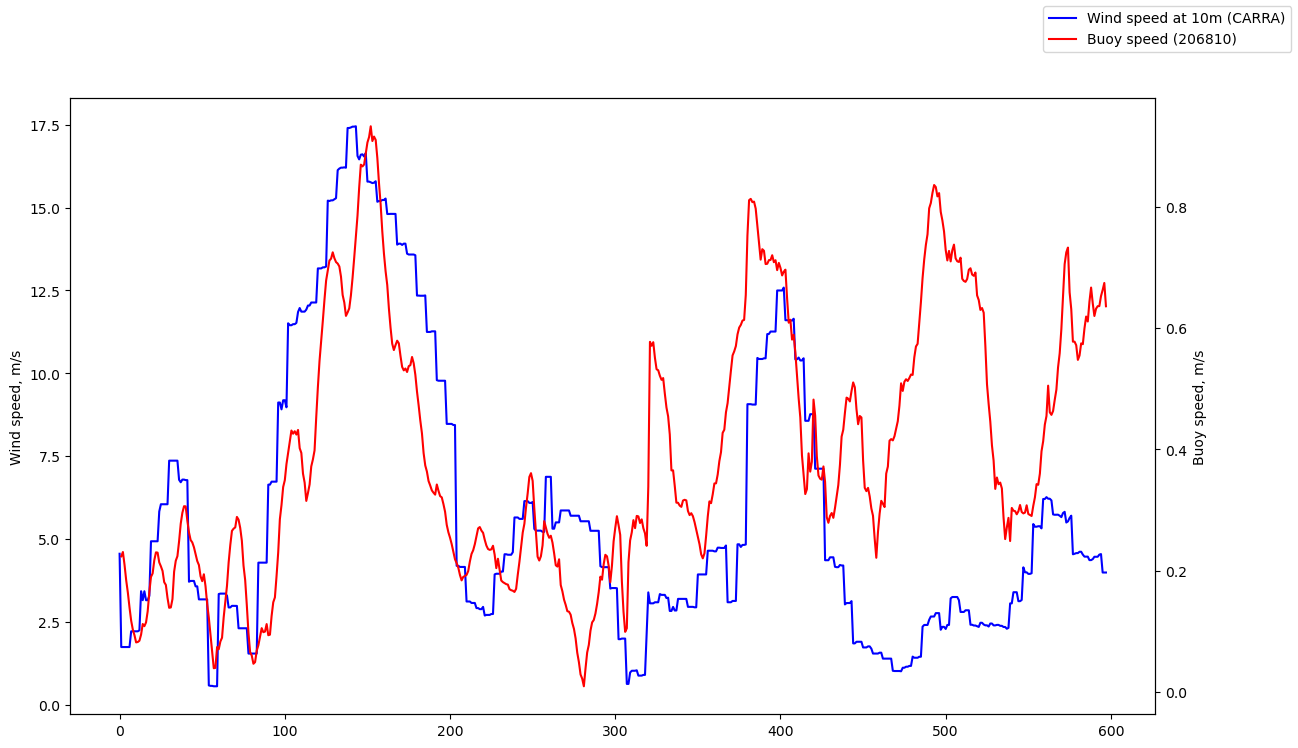

In [16]:
# Let's plot wind speed from CARRA against buoy speed (both in m/s)
fig, myax = plt.subplots(figsize=(14,8))
myax2 = myax.twinx()
b.data['drifter_206810_coords.txt']['si10'].plot(ax=myax, c='b', ylabel='Wind speed, m/s', label='Wind speed at 10m (CARRA)')
b.data['drifter_206810_coords.txt']['Speed'].plot(ax=myax2, c='r', ylabel='Buoy speed, m/s', label='Buoy speed (206810)')
fig.legend(loc="upper right")